![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/35.0.Analyse_Veterinary_Documents_with_Healthcare_NLP.ipynb)

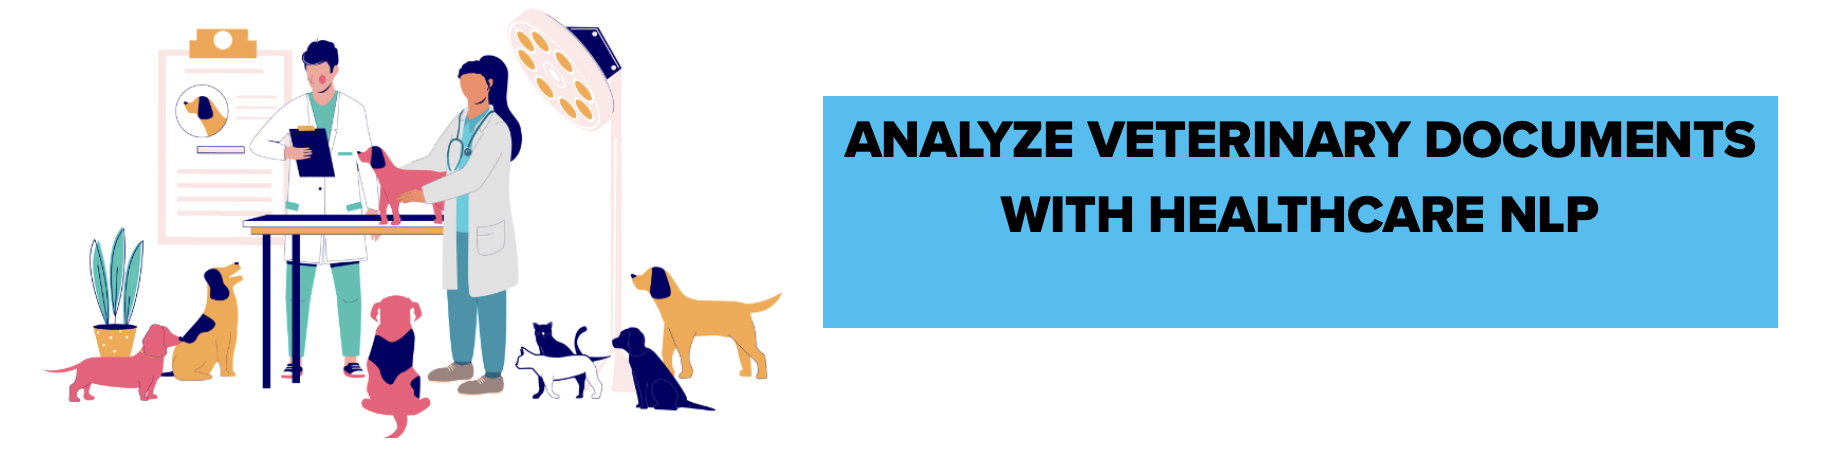

 📌 **In this notebook, we explore the process of recognizing, extracting, and analyzing entities in veterinary documents using Healthcare NLP.**

Specifically focusing on Named Entity Recognition (NER), Assertion Status, Relation Extraction, and Entity Resolution. These models enable us to identify and understand complex entities and their relationships within clinical texts, tailored specifically for veterinary purposes.

📍 Veterinary documents contain a wealth of information critical to animal care, including diagnoses, treatment plans, and medical histories. However, the unstructured nature of these texts makes extracting pertinent information challenging.

🔍 **We will leverage Healthcare NLP to process veterinary documents efficiently. Our approach includes:**

1. Named Entity Recognition (NER): Identifying entities like animal species, symptoms, medications, and procedures from the text.
2. Assertion Status: Determining the presence and condition of these entities, such as confirming whether a symptom is current or historical.
3. Relation Extraction: Linking entities to one another to understand complex relationships, like which medication is prescribed for which condition.
4. Entity Resolution: Resolving entities to standardized terms to ensure consistency across different documents.


🔖 **By the end of this notebook, you will learn how to:**

- Utilize Healthcare NLP models to extract and interpret complex medical information from unstructured veterinary texts.
- Apply these techniques to improve the accuracy and efficiency of data extraction for enhanced decision-making in veterinary practices.
- Visualize the NER, relationships, assertions and entity resolutions using **[`Spark NLP Display`](https://sparknlp.org/docs/en/display)** library that is an open-source library used for visualizing the annotations generated with Healthcare NLP. This makes the insights gained from text analysis more accessible and actionable.
- Transform raw text into structured data.

# ⚒️ Setup and Import Libraries

In [ ]:
! pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.settings.enforce_versions=False
nlp.install(refresh_install=True)

In [4]:
from johnsnowlabs import nlp, medical
# Automatically load license data and start a session with all jars user has access to

spark = nlp.start()

👌 Detected license file /content/5.5.3.spark_nlp_for_healthcare.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==5.5.2, 💊Spark-Healthcare==5.5.3, running on ⚡ PySpark==3.4.0


In [5]:
spark

In [6]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

import pandas as pd
import json
import string
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
from IPython.display import display, HTML

style_config = """
<style>
div.colab-cell {
    min-height: 200px;
    max-height: 500px;
    background-color: #FFFFFF;
    line-height: 2.0;
}
</style>
"""

display(HTML(style_config))

# 🔗 Initial NLP Components

📍 In this section, we'll demonstrate the practical application of Healthcare NLP using a sample veterinary note. Through this example, you'll see how our selected NLP models work in real scenarios to extract, analyze, and interpret data from unstructured veterinary texts.

In [8]:
text = ["""Veterinary Report

Patient: Dino
Species: Caninem
Breed: Golden Retriever
Age: 4 years
Sex: Male, neutered
Owner: John Doe
Date of Examination: June 10, 2024
Veterinarian: Dr. Jane Smith, DVM

---

Chief Complaint:
Dino presented to the clinic with lethargy, inappetence, and a history of occasional vomiting. The owner also reported frequent scratching and licking of the paws and a peculiar behavior of eating feces (coprophagy).

History:
Dino is a four-year-old neutered male Golden Retriever. He has been generally healthy, with no significant past medical history. Vaccinations and deworming are up to date. He is on a monthly flea and tick preventative. The owner realized that decrease in activity levels and appetite over the past two weeks, along with occasional vomiting and increased scratching.


Physical Examination:
- Temperature: 102.5°F (slightly elevated)
- Heart Rate: 120 bpm (within normal limits)
- Respiratory Rate: 30 breaths per minute (within normal limits)
- Body Condition Score (BCS): 5/9 (ideal)
- Mucous Membranes: Pink, moist
- Capillary Refill Time (CRT): <2 seconds
- Coat and Skin: Mild erythema and alopecia observed on the paws and underbelly. Evidence of tick bites on the neck and back.
- Ears: Clean, no discharge
- Eyes: Clear, no discharge


Diagnostic Tests:

1. Blood Work:
   - Complete Blood Count (CBC):
     - White Blood Cells (WBC): 18,000/µL (indicating infection)
     - Neutrophils: 80%
     - Lymphocytes: 10% (within normal limits)
     - Red Blood Cells Test (RBC): 6.2 million/µL (within normal limits)
     - Hematocrit (HCT): 45% (within normal limits)

   - Biochemistry Panel:
     - Kidney Function: Within normal limits

2. Tick-Borne Disease Panel:
   - Anaplasma phagocytophilum: Positive
   - Borrelia burgdorferi (Lyme disease): Negative
   - Babesia: Negative

3. Serology:
   - Seroconversion for Ehrlichia canis and Anaplasma phagocytophilum:** Confirmed by the presence of specific antibodies indicating recent exposure.

4. Fecal Analysis:
   - Direct Smear: No protozoal parasites observed
   - Giardia Antigen Test: Negative

5. Skin Scraping and Cytology:
   - Scraping: No mites observed
   - Cytology: Presence of secondary bacterial infection (cocci and rods observed)

Diagnosis:
1. Ehrlichiosis and Anaplasmosis: Based on positive  Tick-Borne Disease Panel and clinical signs.
2. Secondary Bacterial Skin Infection: Indicated by skin cytology.
3. Roundworm Infection (Toxocara canis) : Confirmed.
4. Coprophagy: Behavioral issue potentially related to dietary deficiency or boredom.

Treatment Plan:

1. Antibiotics:
   - Doxycycline: 5 mg/kg BID for 28 days for Ehrlichiosis and Anaplasmosis.
   - Cephalexin: 20 mg/kg BID for 14 days for secondary bacterial infection.

2. Dehelmintization:
   - Fenbendazole: 50 mg/kg once daily for 3 days to treat roundworms.

3. Flea and Tick Preventative:
   - Bravecto: Administered to kill existing ticks and prevent further infestations.

4. Behavioral Modification for Coprophagy:
   - Dietary Changes: Introduce a high-fiber diet or a commercial diet formulated to deter coprophagy.
   - Training and Enrichment: Increase physical and mental stimulation through play, exercise, and training sessions.

5. Supportive Care:
   - Probiotics: To support gut health during antibiotic therapy.
   - Omega-3 Fatty Acids: Supplement to improve skin and coat condition.

Follow-Up:
1. Recheck Appointment: Scheduled in 2 weeks to assess response to treatment and adjust medications if necessary.
2. Repeat Blood Work: In 4 weeks to ensure resolution of tick-borne diseases.
3. Fecal Examination: In 3 weeks to confirm elimination of roundworms.

Owner Instructions:
- Administer all prescribed medications as directed.
- Monitor for any side effects such as vomiting, diarrhea, or changes in behavior.
- Prevent Max from eating feces by keeping the yard clean and using positive reinforcement techniques.
- Return for follow-up appointments and notify the clinic of any concerns or changes in Max’s condition."""]

📍 Here, we'll explore the basic stages of Healthcare NLP pipeline that will help us preparing the dataset for NER and all the other downstreaming tasks we have.

- Document Assembler starts the process by turning text into a form that Healthcare NLP can work with.
- Sentence Detector finds and marks the sentences in the text, helping us analyze each one separately.
- Tokenizer breaks down sentences into words or small pieces, which is crucial for understanding the text in detail.
- Word Embeddings turns words into numerical values that represent their meaning, helping the computer understand word relationships.

In [9]:
document_assembler = nlp.DocumentAssembler()\
		.setInputCol("text")\
		.setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", 'clinical/models') \
    .setInputCols("document") \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
		.setInputCols(["sentence"])\
		.setOutputCol("token")\
		.setContextChars(['.',',',';','!','?','*','(',')'])\
		.setSplitChars(["-",":","_","\n","‘"])\

embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
		.setInputCols(["sentence", "token"])\
		.setOutputCol("embeddings")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


# 🔗 NER Pipeline

📍 The deep neural network architecture for NER model in Healthcare NLP is `BiLSTM-CNN-Char framework`. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols (`Named Entity Recognition with Bidirectional LSTM-CNNs`). It is a neural network architecture that automatically detects word and character-level features using a `hybrid bidirectional LSTM and CNN architecture`, eliminating the need for most feature engineering steps.

📍 In the original framework, the CNN extracts a fixed length feature vector from character-level features. For each word, these vectors are concatenated and fed to the BLSTM network and then to the output layers. They employed a stacked bi-directional recurrent neural network with long short-term memory units to transform word features into named entity tag scores. The extracted features of each word are fed into a forward LSTM network and a backward LSTM network. The output of each network at each time step is decoded by a linear layer and a log-softmax layer into log-probabilities for each tag category. These two vectors are then simply added together to produce the final output. `In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word embeddings is used for word features, 25-dimension character embeddings is used for char features, and capitalization features` (allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used for case features.

🔍  Please see the [Clinical_Named_Entity_Recognition_Model](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb) notebook for more examples

## 🔖 Clinical Condition Entity Detection

📍 In this section, we will focus on extracting clinical information such as problems, disorders, diseases, symptoms, findings, and clinical signs from veterinary documents.

🩸 Here we will use the following pretrained named entity recognition models by whitelisting the relevant labels for entity detection and merge them using `ChunkMergerApproach` to have a single chunk at the end:


- [ner_jsl](https://nlp.johnsnowlabs.com/2022/10/19/ner_jsl_en.html)
- [bert_token_classifier_ner_clinical](https://nlp.johnsnowlabs.com/2022/01/06/bert_token_classifier_ner_clinical_en.html)



🎈 For tasks requiring even more specialized extraction capabilities or for different types of medical data, using other models may be necessary. You can explore and integrate additional models from Healthcare NLP. Visit the [Model Hub](https://nlp.johnsnowlabs.com/models) to find models that can be adapted to specific needs not covered by the standard models in this pipeline.





In [10]:
jsl_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
		.setInputCols(["sentence", "token", "embeddings"]) \
		.setOutputCol("jsl_ner")

jsl_ner_converter = medical.NerConverter() \
		.setInputCols(["sentence", "token", "jsl_ner"]) \
		.setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Symptom", "Injury_or_Poisoning", "Hypertension","Diabetes", "Overweight", "Allergen", "Oncological",
		               "Disease_Syndrome_Disorder","Kidney_Disease", "Cerebrovascular_Disease","Heart_Disease",
                   "Communicable_Disease", "ImagingFindings", "EKG_Findings","VS_Finding"])

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.BertForTokenClassification.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols(["sentence","token"])\
    .setOutputCol("clinical_ner")

clinical_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence","token","clinical_ner"])\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["PROBLEM"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("jsl_ner_chunk","clinical_ner_chunk")\
    .setOutputCol("merged_ner_chunk")\
    .setMergeOverlapping(True)

nlp_pipeline = nlp.Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    jsl_ner,
    jsl_ner_converter,
    clinical_ner,
    clinical_ner_converter,
		chunk_merger
])

ner_jsl download started this may take some time.
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [11]:
data = spark.createDataFrame(text, nlp.StringType()).toDF("text")

results = nlp_pipeline.fit(data).transform(data)

🎯 This code is crucial for processing and visualizing the results of named entity recognition tasks. It structures the output in a clear, easy-to-analyze manner by separating out each recognized entity, its position, type, and confidence level, thereby facilitating deeper analysis or further processing steps such as validation or integration into databases.

In [12]:
results.select(F.explode(F.arrays_zip(results.merged_ner_chunk.result,
                                      results.merged_ner_chunk.begin,
                                      results.merged_ner_chunk.end,
                                      results.merged_ner_chunk.metadata)).alias("cols")) \
       .select(F.expr("cols['0']").alias("chunk"),
               F.expr("cols['1']").alias("begin"),
               F.expr("cols['2']").alias("end"),
               F.expr("cols['3']['entity']").alias("ner_label"),
               F.expr("cols['3']['confidence']").alias("confidence")).show(truncate=False)

+-------------------------------+-----+----+-------------------------+----------+
|chunk                          |begin|end |ner_label                |confidence|
+-------------------------------+-----+----+-------------------------+----------+
|lethargy                       |249  |256 |Symptom                  |0.9459    |
|inappetence                    |259  |269 |Symptom                  |0.9775    |
|occasional vomiting            |289  |307 |PROBLEM                  |0.9803288 |
|frequent scratching            |334  |352 |PROBLEM                  |0.5485245 |
|licking of the paws            |358  |376 |Symptom                  |0.6805    |
|a                              |382  |382 |PROBLEM                  |0.5024668 |
|behavior of eating feces       |393  |416 |Symptom                  |0.45599997|
|coprophagy                     |419  |428 |PROBLEM                  |0.98618686|
|decrease in activity levels    |685  |711 |Symptom                  |0.44959998|
|occasional vomi

💣 🧨 `LightPipeline` is optimized for low-latency transformations, making it ideal for quickly testing and iterating over NLP models. It is particularly useful when you need to process small amounts of text.

It simplifies the process of applying models to text, especially when real-time or on-the-fly text processing is required.

By using `LightPipeline`, you can get immediate feedback on the performance of your NLP pipelines. This is crucial during development and testing phases, where you might need to update the pipeline based on preliminary results.

In [13]:
light_model_4_1 = nlp.LightPipeline(nlp_pipeline.fit(data))

light_result_4_1 = light_model_4_1.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []
confidence = []

for n in light_result_4_1[0]['merged_ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    sentence.append(n.metadata['sentence'])
    confidence.append(n.metadata["confidence"])


df_clinical_4 = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end,
                   'sentence_id':sentence, 'entities':entities, 'confidence':confidence})

df_clinical_4

,chunks,begin,end,sentence_id,entities,confidence
0,lethargy,249,256,9,Symptom,0.9459
1,inappetence,259,269,9,Symptom,0.9775
2,occasional vomiting,289,307,9,PROBLEM,0.9803288
3,frequent scratching,334,352,10,PROBLEM,0.5485245
4,licking of the paws,358,376,10,Symptom,0.6805
5,a,382,382,10,PROBLEM,0.5024668
6,behavior of eating feces,393,416,10,Symptom,0.45599997
7,coprophagy,419,428,10,PROBLEM,0.98618686
8,decrease in activity levels,685,711,15,Symptom,0.44959998
9,occasional vomiting,762,780,15,PROBLEM,0.9526708


`NerVisualizer` highlights the named entities that are identified by Healthcare NLP and also displays their labels as decorations on top of the analyzed text.

In [14]:
visualiser = nlp.viz.NerVisualizer()

# .collect method for visualization. it will return same output with LP
#visualiser.display(results.collect()[0], label_col='merged_ner_chunk', document_col='document')

visualiser.display(light_result_4_1[0], label_col='merged_ner_chunk', document_col='document', save_path="display_result_firstner.html")


🔐 Let's save the results, so we can use it later.

In [15]:
df_clinical_4.to_csv('NER_4.csv')

## 🔖 Laboratory Findings

🎈 Now we will identify key medical terms and test results such as cholesterol levels, blood pressure, imaging findings, and other vital statistics that are crucial for diagnosing and monitoring the health of animals. To do that, we will build a NER pipeline to extract specific entities related to laboratory tests and their results from veterinary documents.

We will use the following models here:

- [ner_jsl](https://nlp.johnsnowlabs.com/2022/10/19/ner_jsl_en.html)
- [ner_vop](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_en.html)
- [bert_token_classifier_ner_clinical](https://nlp.johnsnowlabs.com/2022/01/06/bert_token_classifier_ner_clinical_en.html)
- [ner_radiology](https://nlp.johnsnowlabs.com/2021/03/31/ner_radiology_en.html)


In [16]:
jsl_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
		.setInputCols(["sentence", "token", "embeddings"]) \
		.setOutputCol("jsl_ner")

jsl_ner_converter = medical.NerConverter() \
		.setInputCols(["sentence", "token", "jsl_ner"]) \
		.setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Test_Result", "Total_Cholesterol","HDL","LDL","Triglycerides","Imaging_Findings", "BMI",
                   "Temperature", "VS_Finding", "Respiration", "O2_Saturation", "Substance", "Blood_Pressure",
                   "EKG_Findings", "Height"])


ner_vop = medical.NerModel.pretrained("ner_vop", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_vop")

ner_converter_vop = medical.NerConverter() \
    .setInputCols(["sentence", "token", "ner_vop"]) \
    .setOutputCol("ner_chunk_vop")\
    .setWhiteList(["Test", "TestResult"])

ner_clinical_bftc = medical.BertForTokenClassification.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("ner_bftc")

ner_converter_bftc = medical.NerConverter() \
    .setInputCols(["sentence", "token", "ner_bftc"]) \
    .setOutputCol("ner_chunk_bftc")\
    .setWhiteList(["TEST"])

radiology_ner = medical.NerModel.pretrained("ner_radiology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = medical.NerConverter()\
 	  .setInputCols(["sentence", "token", "ner"])\
 	  .setOutputCol("ner_chunk")\
    .setWhiteList(["Test"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("ner_chunk", "ner_chunk_vop", "ner_chunk_bftc", "jsl_ner_chunk")\
    .setOutputCol("merged_ner_chunk")\
    .setMergeOverlapping(True)

nlp_pipeline_lab_result = nlp.Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    jsl_ner,
    jsl_ner_converter,
    ner_vop,
    ner_converter_vop,
    ner_clinical_bftc,
    ner_converter_bftc,
    radiology_ner,
    ner_converter,
		chunk_merger
  ])

ner_jsl download started this may take some time.
[OK!]
ner_vop download started this may take some time.
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
[OK!]
ner_radiology download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [17]:
data = spark.createDataFrame(text, nlp.StringType()).toDF("text")

results = nlp_pipeline_lab_result.fit(data).transform(data)

In [18]:
results.select(F.explode(F.arrays_zip(results.merged_ner_chunk.result,
                                      results.merged_ner_chunk.begin,
                                      results.merged_ner_chunk.end,
                                      results.merged_ner_chunk.metadata)).alias("cols")) \
       .select(F.expr("cols['0']").alias("chunk"),
               F.expr("cols['1']").alias("begin"),
               F.expr("cols['2']").alias("end"),
               F.expr("cols['3']['entity']").alias("ner_label"),
               F.expr("cols['3']['confidence']").alias("confidence")).show(truncate=False)

+---------------------------------------+-----+----+-----------+----------+
|chunk                                  |begin|end |ner_label  |confidence|
+---------------------------------------+-----+----+-----------+----------+
|Examination                            |131  |141 |TEST       |0.6773681 |
|Physical Examination                   |810  |829 |TEST       |0.9439472 |
|Temperature: 102.5°F                   |834  |853 |Temperature|0.94665   |
|slightly elevated                      |856  |872 |VS_Finding |0.2247    |
|Heart Rate                             |877  |886 |TEST       |0.91514504|
|120 bpm                                |889  |895 |TestResult |0.49725   |
|normal limits                          |905  |917 |TestResult |0.5525    |
|Respiratory Rate: 30 breaths per minute|922  |960 |Respiration|0.88525003|
|normal limits                          |970  |982 |TestResult |0.50135   |
|Body Condition Score                   |987  |1006|Test       |0.58559996|
|BCS)       

In [20]:
visualiser = nlp.viz.NerVisualizer()

# .collect method for visualization
visualiser.display(results.collect()[0], label_col='merged_ner_chunk', document_col='document', save_path="display_result_secondner.html")


## 🔖 Applied Procedure and Treatment Detection

🎈 In this section, we will implement a specialized NLP pipeline to extract crucial information related to treatments and procedures from veterinary documents. This extraction focuses on identifying detailed descriptions of medical treatments, drugs, and procedural interventions that are crucial for effective veterinary care.

Using pretrained named entity recognition deep learning model for clinical terms:

- [ner_jsl](https://nlp.johnsnowlabs.com/2022/10/19/ner_jsl_en.html): This is a general clinical NER model that can identify a wide range of medical entities.
- [ner_clinical_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_clinical_large_en.html): This model is specifically trained on clinical text and can recognize various medical terms and concepts.
- [ner_posology_langtest](https://nlp.johnsnowlabs.com/2023/07/28/ner_posology_langtest_en.html): This model focuses on identifying information related to drug dosage and administration.







In [21]:
posology_ner = medical.NerModel.pretrained("ner_posology_langtest","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("posology_ner")

posology_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence","token","posology_ner"])\
    .setOutputCol("posology_ner_chunk")\
		.setWhiteList(["DRUG"])

jsl_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
		.setInputCols(["sentence", "token", "embeddings"]) \
		.setOutputCol("jsl_ner")

jsl_ner_converter = medical.NerConverter() \
		.setInputCols(["sentence", "token", "jsl_ner"]) \
		.setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Treatment","Drug_BrandName","Drug_Ingredient","Oxygen_Therapy","Procedure"])\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Drug_Ingredient": "Drug"})

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.NerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("clinical_ner")

clinical_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence","token","clinical_ner"])\
    .setOutputCol("clinical_ner_chunk")\
    .setWhiteList(["TREATMENT"])

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("posology_ner_chunk", "clinical_ner_chunk", "jsl_ner_chunk")\
    .setOutputCol("merged_ner_chunk")\
    .setMergeOverlapping(True)

nlp_pipeline_procedure = nlp.Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    posology_ner,
    posology_ner_converter,
    jsl_ner,
    jsl_ner_converter,
    clinical_ner,
    clinical_ner_converter,
		chunk_merger
  ])

ner_posology_langtest download started this may take some time.
[OK!]
ner_jsl download started this may take some time.
[OK!]
ner_clinical_large download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [22]:
data = spark.createDataFrame(text, nlp.StringType()).toDF("text")

results = nlp_pipeline_procedure.fit(data).transform(data)

In [23]:
results.select(F.explode(F.arrays_zip(results.merged_ner_chunk.result,
                                      results.merged_ner_chunk.begin,
                                      results.merged_ner_chunk.end,
                                      results.merged_ner_chunk.metadata)).alias("cols")) \
       .select(F.expr("cols['0']").alias("chunk"),
               F.expr("cols['1']").alias("begin"),
               F.expr("cols['2']").alias("end"),
               F.expr("cols['3']['entity']").alias("ner_label"),
               F.expr("cols['3']['confidence']").alias("confidence")).show(truncate=False)

+---------------------------------+-----+----+---------+----------+
|chunk                            |begin|end |ner_label|confidence|
+---------------------------------+-----+----+---------+----------+
|Vaccinations                     |571  |582 |TREATMENT|0.9973    |
|deworming                        |588  |596 |TREATMENT|0.9316    |
|flea and tick preventative       |633  |658 |TREATMENT|0.76075   |
|Antibiotics:\n   - Doxycycline   |2585 |2613|DRUG     |0.7863    |
|Cephalexin                       |2680 |2689|DRUG     |0.9904    |
|Dehelmintization                 |2756 |2771|TREATMENT|0.9559    |
|Fenbendazole                     |2779 |2790|DRUG     |0.9938    |
|Flea and Tick Preventative       |2849 |2874|TREATMENT|0.77157503|
|Bravecto                         |2882 |2889|TREATMENT|0.9975    |
|Behavioral Modification          |2966 |2988|TREATMENT|0.69995   |
|Coprophagy                       |2994 |3003|Drug     |0.3207    |
|a high-fiber diet                |3038 |3054|TR

In [24]:
visualiser = nlp.viz.NerVisualizer()

res = results.collect()

visualiser.display(res[0], label_col='merged_ner_chunk', document_col='document', save_path="display_result_thirdner.html")

# 🔗 Assertion Status Detection


🎗️ Assertion models are integral in processing medical documents because they enable more nuanced understanding of patient data by determining the assertion status of each entity. So we can filter the entities according to their assertions and increase the accuracy in our analysis.

We used the following assertion status detection model here but you can use any assertion models according to their labels or performance on your data:

- [assertion_jsl_large](https://nlp.johnsnowlabs.com/2021/07/24/assertion_jsl_large_en.html)

🔍  Please see the [Clinical_Assertion_Model](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/2.Clinical_Assertion_Model.ipynb) notebook for more examples.

📥 Visit the [Model Hub](https://nlp.johnsnowlabs.com/models) to find models that can be adapted to specific needs not covered by the standard models in this pipeline.

📝 In our process, we need to filter out the entities which have Present assertion label.

In [25]:
assertion_text = ["Dr. Smith examined the 7-year-old Labrador Retriever named Bella. The patient came with symptoms of lethargy and occasional vomiting over the past two days. Physical examination revealed mild dehydration. Bella is currently under medication for chronic kidney disease, and the owner reports compliance with the prescribed renal diet. An X-ray was also conducted, confirming no foreign bodies present in the abdomen."]

In [26]:
posology_ner = medical.NerModel.pretrained("ner_posology_langtest","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("posology_ner")

posology_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence","token","posology_ner"])\
    .setOutputCol("posology_ner_chunk")\
	  .setWhiteList(["DRUG"])

jsl_ner = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models") \
	  .setInputCols(["sentence", "token", "embeddings"]) \
	  .setOutputCol("jsl_ner")

jsl_ner_converter = medical.NerConverter() \
	  .setInputCols(["sentence", "token", "jsl_ner"]) \
	  .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(["Symptom", "Injury_or_Poisoning", "Hypertension","Diabetes", "Overweight", "Allergen", "Oncological",
                   "Disease_Syndrome_Disorder","Kidney_Disease", "Cerebrovascular_Disease","Heart_Disease", "Communicable_Disease",
                   "ImagingFindings", "EKG_Findings","VS_Finding",
                   "Respiration", "Hyperlipidemia", "Pregnancy", "Obesity", "Psychological_Condition",
                   "Test_Result", "Total_Cholesterol", "HDL", "LDL","Triglycerides", "Imaging_Technique", "BMI",
                   "Treatment","Drug","Oxygen_Therapy","Procedure","Vaccine"])

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = medical.NerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("clinical_ner")

clinical_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence","token","clinical_ner"])\
    .setOutputCol("clinical_ner_chunk")

# merge the chunks into a single ner_chunk
chunk_merger = medical.ChunkMergeApproach()\
    .setInputCols("posology_ner_chunk","jsl_ner_chunk","clinical_ner_chunk")\
    .setOutputCol("merged_ner_chunk")\
    .setMergeOverlapping(True)

# Assertion model trained on i2b2 (sampled from MIMIC) dataset
clinical_assertion = medical.AssertionDLModel.pretrained("assertion_jsl_large", "en", "clinical/models") \
    .setInputCols(["sentence", "merged_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")\
    .setEntityAssertionCaseSensitive(False)

assertion_filterer = medical.AssertionFilterer()\
    .setInputCols("sentence","merged_ner_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setCaseSensitive(False)\
    .setWhiteList(["Present"])

nlp_pipeline_assertion = nlp.Pipeline().setStages([
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
	  posology_ner,
		posology_ner_converter,
    jsl_ner,
    jsl_ner_converter,
    clinical_ner,
    clinical_ner_converter,
		chunk_merger,
		clinical_assertion,
    assertion_filterer
  ])

ner_posology_langtest download started this may take some time.
[OK!]
ner_jsl download started this may take some time.
[OK!]
ner_clinical_large download started this may take some time.
[OK!]
assertion_jsl_large download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [27]:
data = spark.createDataFrame(assertion_text, nlp.StringType()).toDF("text")

results = nlp_pipeline_assertion.fit(data).transform(data)

🪅 Let's check assertion status of the whole detected chunks first.

In [28]:
results.select(F.explode(F.arrays_zip(results.merged_ner_chunk.result,
                                      results.merged_ner_chunk.begin,
                                      results.merged_ner_chunk.end,
                                      results.merged_ner_chunk.metadata,
                                      results.assertion.result)).alias("cols")) \
       .select(F.expr("cols['3']['sentence']").alias("sent_id"),
               F.expr("cols['1']").alias("begin"),
               F.expr("cols['2']").alias("end"),
               F.expr("cols['0']").alias("ner_chunk"),
               F.expr("cols['3']['entity']").alias("ner_label"),
               F.expr("cols['4']").alias("assertion")).show(50, truncate=False)

+-------+-----+---+----------------------+--------------+---------+
|sent_id|begin|end|ner_chunk             |ner_label     |assertion|
+-------+-----+---+----------------------+--------------+---------+
|1      |100  |107|lethargy              |Symptom       |present  |
|1      |113  |131|occasional vomiting   |PROBLEM       |present  |
|2      |157  |176|Physical examination  |TEST          |present  |
|2      |187  |202|mild dehydration      |PROBLEM       |present  |
|3      |230  |239|medication            |TREATMENT     |planned  |
|3      |245  |266|chronic kidney disease|Kidney_Disease|present  |
|4      |334  |341|An X-ray              |TEST          |present  |
|4      |377  |390|foreign bodies        |Symptom       |absent   |
+-------+-----+---+----------------------+--------------+---------+



🪅 Now we can check the `Present` entities only.

In [29]:
results.select(F.explode(F.arrays_zip(results.assertion_filtered.result,
                                      results.assertion_filtered.metadata)).alias("cols")) \
       .select(F.expr("cols['0']").alias("chunks"),
               F.expr("cols['1']['entity']").alias("ner_label"),
               F.expr("cols['1']['assertion']").alias("assertion")).show(50, truncate=False)

+----------------------+--------------+---------+
|chunks                |ner_label     |assertion|
+----------------------+--------------+---------+
|lethargy              |Symptom       |present  |
|occasional vomiting   |PROBLEM       |present  |
|Physical examination  |TEST          |present  |
|mild dehydration      |PROBLEM       |present  |
|chronic kidney disease|Kidney_Disease|present  |
|An X-ray              |TEST          |present  |
+----------------------+--------------+---------+



📺  `AssertionVisualizer` displays on top of the labeled entities the assertion status that was determined by the assertion model.

In [30]:
vis = nlp.viz.AssertionVisualizer()

🪅 You can see visualizer results for assertion and assertion filterer.  

In [31]:
from google.colab import widgets

t = widgets.TabBar(["viz_assertion", "viz_assertion_filtered"])

with t.output_to(0):
    vis.display(results.collect()[0], 'merged_ner_chunk', 'assertion', save_path="example_assertion.html")

with t.output_to(1):
    vis.display(results.collect()[0], 'assertion_filtered', 'assertion', save_path="example_assertion.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🔗 Relation Extraction

🌪️☄️ If you have a task like which treatments are used for which diseases, or which clinical conditions are affected by which procedures, or detect orders of the clinical events, check drug-dosage relations, etc., we should extract the relations between the entities. You can use Healthcare NLP relation extraction models for solving these kinds of prolems.

🔍 Please see the [Clinical_Relation_Extraction](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.Clinical_Relation_Extraction.ipynb) notebook for more detailed information about other types of relation extraction models.

In this section, we wanted to check the relations between the `PROBLEM-TREATMENT` entities, so we used the Generic RE model (generic_re), which can be used between any named entities using the syntactic distances, POS tags, and dependency tree between the entities. You can tune this model by using the setMaxSyntacticDistance param.

📥 Visit the [Model Hub](https://nlp.johnsnowlabs.com/models) to find more models that can be adapted to specific needs not covered by the standard models in this pipeline.

📊 We will create a generic function that will help us to easily view and analyze the results of a relation extraction model by organizing them into a Pandas DataFrame.

In [32]:
# get relations in a pandas dataframe

def get_relations_df (results, rel_col='relations', chunk_col='clinical_ner_chunk'):
    rel_pairs=[]
    chunks = []

    for rel in results[0][rel_col]:
        rel_pairs.append((
            rel.metadata['sentence'],
            rel.metadata['entity1_begin'],
            rel.metadata['entity1_end'],
            rel.metadata['chunk1'],
            rel.metadata['entity1'],
            rel.metadata['entity2_begin'],
            rel.metadata['entity2_end'],
            rel.metadata['chunk2'],
            rel.metadata['entity2'],
            rel.result,
            rel.metadata['confidence'],
        ))

    for chunk in results[0][chunk_col]:
        chunks.append((
            chunk.begin,
            chunk.end,
            chunk.result,
        ))

    rel_df = pd.DataFrame(rel_pairs, columns=['sentence', 'entity1_begin', 'entity1_end', 'chunk1', 'entity1', 'entity2_begin', 'entity2_end', 'chunk2', 'entity2', 'relation', 'confidence'])

    chunks_df = pd.DataFrame(chunks, columns = [ "begin", "end", "chunk"])
    chunks_df.begin = chunks_df.begin.astype(str)
    chunks_df.end = chunks_df.end.astype(str)

    result_df = pd.merge(rel_df, chunks_df, left_on=["entity1_begin", "entity1_end", "chunk1"], right_on=["begin", "end", "chunk"])[list(rel_df.columns)]


    return result_df

In [33]:
clinical_ner = medical.BertForTokenClassification.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("clinical_ner")

clinical_ner_converter = medical.NerConverter()\
    .setInputCols(["sentence", "token", "clinical_ner"])\
    .setOutputCol("clinical_ner_chunk")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")

dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

clinical_re_Model = medical.RelationExtractionModel()\
    .pretrained("generic_re", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "clinical_ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["PROBLEM-TREATMENT"])

re_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    clinical_ner,
    clinical_ner_converter,
    pos_tagger,
    dependency_parser,
    clinical_re_Model
])

bert_token_classifier_ner_clinical download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]


In [34]:
empty_data = spark.createDataFrame([[""]]).toDF("text")

model = re_pipeline.fit(empty_data)

In [35]:
lmodel = nlp.LightPipeline(model)
annotations = lmodel.fullAnnotate(text)

In [36]:
rel_df = get_relations_df (annotations)
rel_df = rel_df[(rel_df.relation!="O")]
rel_df

,sentence,entity1_begin,entity1_end,chunk1,entity1,entity2_begin,entity2_end,chunk2,entity2,relation,confidence
0,57,2585,2595,Antibiotics,TREATMENT,2644,2655,Ehrlichiosis,PROBLEM,TREATMENT-PROBLEM,1.0
1,57,2603,2613,Doxycycline,TREATMENT,2644,2655,Ehrlichiosis,PROBLEM,TREATMENT-PROBLEM,1.0
2,57,2603,2613,Doxycycline,TREATMENT,2661,2672,Anaplasmosis,PROBLEM,TREATMENT-PROBLEM,1.0
3,58,2680,2689,Cephalexin,TREATMENT,2721,2749,secondary bacterial infection,PROBLEM,TREATMENT-PROBLEM,1.0
4,60,2779,2790,Fenbendazole,TREATMENT,2833,2842,roundworms,PROBLEM,TREATMENT-PROBLEM,1.0
5,62,2882,2889,Bravecto,TREATMENT,2913,2926,existing ticks,PROBLEM,TREATMENT-PROBLEM,1.0
6,63,2966,2988,Behavioral Modification,TREATMENT,2994,3003,Coprophagy,PROBLEM,TREATMENT-PROBLEM,1.0
7,64,3038,3054,a high-fiber diet,TREATMENT,3097,3106,coprophagy,PROBLEM,TREATMENT-PROBLEM,1.0
8,64,3059,3075,a commercial diet,TREATMENT,3097,3106,coprophagy,PROBLEM,TREATMENT-PROBLEM,1.0


`RelationExtractionVisualizer` highlights the relations between the named entities that are identified by Healthcare NLP and also displays their labels as decorations on top of the analyzed text.

In [37]:
vis = nlp.viz.RelationExtractionVisualizer()

vis.display(annotations[0], 'relations', show_relations=True, save_path="example_relation.html") # default show_relations: True


# 🔗 Entity Resolutions

🏷️ In this section, we'll explore a comprehensive pipeline designed to enhance the understanding and usability of veterinary clinical documents by mapping identified medical entities to standardized `SNOMED` and `MESH` Veterinary codes.

## 🔖 SNOMED

Using that resolver model:
- [sbiobertresolve_snomed_veterinary](https://nlp.johnsnowlabs.com/2024/06/10/sbiobertresolve_snomed_veterinary_en.html)

This model maps veterinary-related entities and concepts to SNOMED codes using `sbiobert_base_cased_mli` Sentence Bert Embeddings.


🔍  Please see the [Clinical_Entity_Resolvers](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb) notebook for more examples

In [38]:
ner_jsl = medical.NerModel.pretrained("ner_jsl", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")\

ner_jsl_converter = medical.NerConverter()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("jsl_ner_chunk")\
    .setWhiteList(['Cerebrovascular_Disease', 'Communicable_Disease', 'Diabetes', 'Disease_Syndrome_Disorder',
                   'EKG_Findings', 'Heart_Disease', 'Hyperlipidemia', 'Hypertension', 'ImagingFindings',
                   'Injury_or_Poisoning', 'Kidney_Disease', 'Obesity', 'Oncological', 'Overweight', 'Pregnancy',
                   'Psychological_Condition'])\

c2doc = nlp.Chunk2Doc()\
    .setInputCols("jsl_ner_chunk")\
    .setOutputCol("doc_ner_chunk")

sbert_embedder = nlp.BertSentenceEmbeddings\
    .pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["doc_ner_chunk"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

snomed_ct_resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_veterinary", "en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

# Build up the pipeline
resolver_pipeline = nlp.Pipeline(
    stages = [
        document_assembler,
        sentence_detector,
        tokenizer,
        embeddings,
        ner_jsl,
        ner_jsl_converter,
        c2doc,
        sbert_embedder,
        snomed_ct_resolver
  ])

ner_jsl download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_snomed_veterinary download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [39]:
data = spark.createDataFrame(text, nlp.StringType()).toDF("text")

results = resolver_pipeline.fit(data).transform(data)

In [40]:
results.select(F.explode(F.arrays_zip(results.snomed_code.result,
                                      results.snomed_code.metadata)).alias("cols")) \
       .select(F.expr("cols['1']['target_text']").alias("resolutions"),
               F.expr("cols['1']['entity']").alias("entity"),
               F.expr("cols['0']").alias("snomed_code"),
               F.expr("cols['1']['resolved_text']").alias("resolutions"),
               F.expr("cols['1']['all_k_results']").alias("all_codes"),
               F.expr("cols['1']['all_k_resolutions']").alias("all_k_resolutions"),
               F.expr("cols['1']['all_k_cosine_distances']").alias("all_k_cosine_distances")).show(truncate=80)

+------------------------+-------------------------+---------------+---------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|             resolutions|                   entity|    snomed_code|                resolutions|                                                                       all_codes|                                                               all_k_resolutions|                                                          all_k_cosine_distances|
+------------------------+-------------------------+---------------+---------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------

📺 `EntityResolverVisualizer` is a special type of NerVisualizer that also displays on top of the labeled entities the clinical codes (ICD-10, SNOMED, RxNorm, CPT etc.) that were determined by the resolver model.

In [41]:
result = results.collect()

In [42]:
visualiser = nlp.viz.EntityResolverVisualizer()

for i in range(len(result)):
  visualiser.display(result[i], 'jsl_ner_chunk', 'snomed_code', save_path="example_resolver.html")

## 🔖 MESH

Using the [sbiobertresolve_mesh_veterinary](https://nlp.johnsnowlabs.com/2025/02/19/sbiobertresolve_mesh_veterinary_en.html) model:

This model maps clinical entities from veterinary notes to MeSH codes utilizing `sbiobert_base_cased_mli` Sentence Bert Embeddings.

🔍 The model leverages MeSH veterinary-related descriptors and supplementary concept datasets for accurate mapping. It efficiently identifies and resolves terms related to animal health, such as diseases and conditions, mapping them to standardized MeSH codes.

🔍  Please see the [Clinical_Entity_Resolvers](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.Clinical_Entity_Resolvers.ipynb) notebook for more examples

In [48]:
document_assembler =nlp.DocumentAssembler()\
	.setInputCol("text")\
	.setOutputCol("document")

sentence_detector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare", "en", "clinical/models") \
	.setInputCols(["document"])\
	.setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
	.setInputCols(["sentence"])\
	.setOutputCol("token")

word_embeddings = nlp.WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
	.setInputCols(["sentence", "token"])\
	.setOutputCol("word_embeddings")

ner = medical.NerModel.pretrained("ner_clinical", "en", "clinical/models") \
	.setInputCols(["sentence", "token", "word_embeddings"]) \
	.setOutputCol("ner")\

ner_converter = medical.NerConverterInternal()\
	.setInputCols(["sentence", "token", "ner"])\
	.setOutputCol("ner_chunk")\
  .setBlackList(["TEST", "TREATMENT"])

chunk2doc = nlp.Chunk2Doc()\
	.setInputCols("ner_chunk")\
	.setOutputCol("ner_chunk_doc")

sbert_embedder = nlp.BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli",'en','clinical/models')\
	.setInputCols(["ner_chunk_doc"])\
  	.setOutputCol("sbert_embeddings")\
  	.setCaseSensitive(False)

resolver = medical.SentenceEntityResolverModel.pretrained("sbiobertresolve_mesh_veterinary","en","clinical/models") \
	.setInputCols(["sbert_embeddings"]) \
	.setOutputCol("mesh_code")\
	.setDistanceFunction("EUCLIDEAN")

pipeline = nlp.Pipeline(stages = [
	document_assembler,
	sentence_detector,
	tokenizer,
	word_embeddings,
	ner,
	ner_converter,
	chunk2doc,
	sbert_embedder,
	resolver])

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_mesh_veterinary download started this may take some time.
[OK!]


🎊 Now we will fit and transform our data on the pipeline we created.

In [49]:
from pyspark.sql.types import StringType

resolver_text = ["The dog is a labrador retriever, 4-year-old, it was brought in with vomiting and diarrhea for the past 2 days. A preliminary diagnosis of canine parvovirus infection was made, and supportive care was recommended. The owner was advised on isolation precautions to prevent the spread of the virus."]

data = spark.createDataFrame(resolver_text, StringType()).toDF("text")

In [50]:
results_mesh = pipeline.fit(data).transform(data)

In [51]:
results_mesh.select(F.explode(F.arrays_zip(results_mesh.mesh_code.result,
                                      results_mesh.mesh_code.metadata)).alias("cols")) \
       .select(F.expr("cols['1']['target_text']").alias("resolutions"),
               F.expr("cols['1']['entity']").alias("entity"),
               F.expr("cols['0']").alias("mesh_code"),
               F.expr("cols['1']['resolved_text']").alias("resolutions"),
               F.expr("cols['1']['all_k_results']").alias("all_codes"),
               F.expr("cols['1']['all_k_resolutions']").alias("all_k_resolutions"),
               F.expr("cols['1']['all_k_cosine_distances']").alias("all_k_cosine_distances")).show(truncate=80)

+---------------------------+-------+---------+-------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                resolutions| entity|mesh_code|        resolutions|                                                                       all_codes|                                                               all_k_resolutions|                                                          all_k_cosine_distances|
+---------------------------+-------+---------+-------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                   vomiting|PROBLEM|  C536228|  periodic vomiting|

📺 Let's visualize our result

In [52]:
result_mesh = results_mesh.collect()

In [54]:
visualiser = nlp.viz.EntityResolverVisualizer()

for i in range(len(result)):
  visualiser.display(result_mesh[i], 'ner_chunk', 'mesh_code', save_path="example_resolver_mesh.html")